# GIK2NX - Assignment 1 - Group 7

Authors:

  - Sebastian Danielsson
  - Jesper Andersson
  - Veronika Engberg

In [114]:
# Import libraries
import seaborn as sns
import numpy as np
import pandas as pd
import random
import mesa
import matplotlib.pyplot as plt
%matplotlib inline


In [115]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        cellmates.remove(self)

        # Filter out cellmates with equal or more wealth
        poorer_cellmates = [cellmate for cellmate in cellmates if cellmate.wealth < self.wealth]

        if poorer_cellmates:
            # Select the cellmate with the least wealth
            min_wealth_cellmate = min(poorer_cellmates, key=lambda cellmate: cellmate.wealth)
            min_wealth_cellmate.wealth += 1
            self.wealth -= 1


    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            a.wealth = random.randint(0, 5)  # Comment out to restore money_agent.ipynb behaviour
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


In [116]:
model = MoneyModel(100, 10, 10)
for i in range(100):
    model.step()
# Print all unique wealth values and their counts
unique, counts = np.unique([agent.wealth for agent in model.schedule.agents], return_counts=True)
print(np.asarray((unique, counts)).T)


[[ 2 49]
 [ 3 51]]


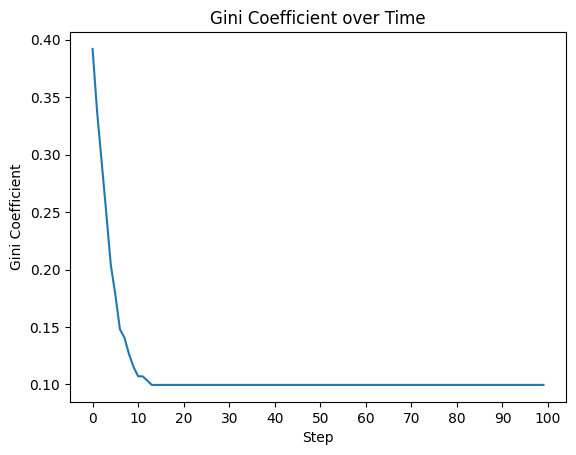

In [132]:
# Plot the Gini coefficient over time
gini = model.datacollector.get_model_vars_dataframe()
plt.plot(gini)
plt.title("Gini Coefficient over Time")
plt.xlabel("Step")
plt.ylabel("Gini Coefficient")
plt.xticks(np.arange(0, 100.1, 10))
plt.show()
